<a href="https://colab.research.google.com/github/Zhiyuan-03/AI_in_Transportation_Exercise/blob/main/ML%2BPOSITION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 1. Load data
from google.colab import files
import pandas as pd
from sklearn.model_selection import train_test_split
# Step 1: Upload the file
uploaded = files.upload()

Saving cf_pair25_v1.csv to cf_pair25_v1.csv


Training pairs: 20 | Testing pairs: 5
Calibrated (MLE with skew-normal) params [a, b, alpha]: [ 0.37062762  0.37172218 -0.05414508]
AIC: 113250.42, BIC: 113273.06

Validation (position RMSE) summary:
       Vehicle_ID_f  RMSE_position
count      5.000000       5.000000
mean    4445.200000       2.255842
std     2617.051719       1.899542
min     1939.000000       0.630562
25%     3054.000000       1.646925
50%     4094.000000       1.684284
75%     4330.000000       1.766906
max     8809.000000       5.550534

Validation (speed RMSE) summary:
       Vehicle_ID_f  RMSE_speed
count      5.000000    5.000000
mean    4445.200000    0.415616
std     2617.051719    0.152373
min     1939.000000    0.238733
25%     3054.000000    0.346935
50%     4094.000000    0.359369
75%     4330.000000    0.502659
max     8809.000000    0.630384


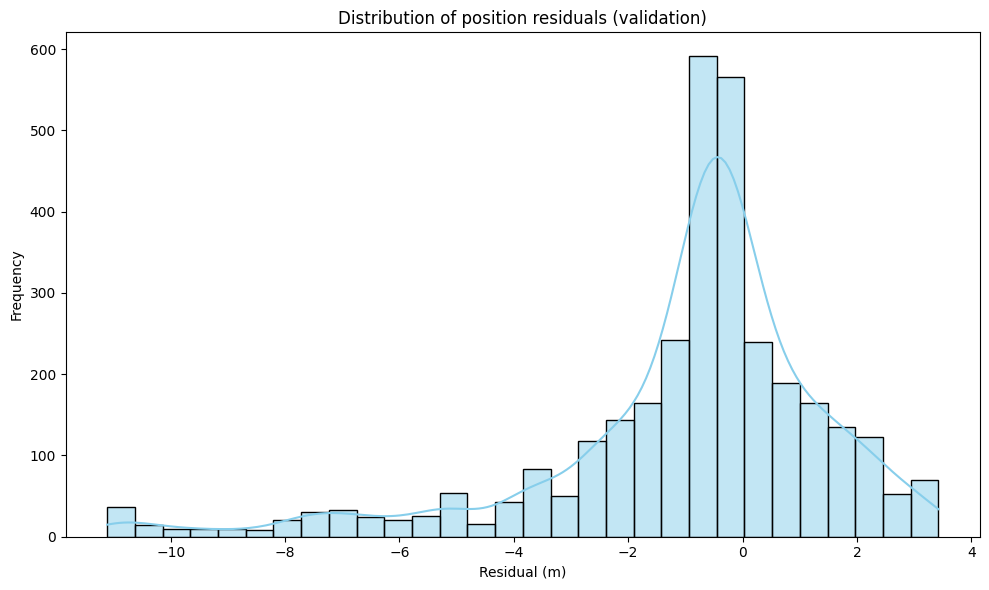

Shapiro–Wilk on position residuals: stat=0.865, p=0.000
Interpretation: Reject normality (p<=0.05)


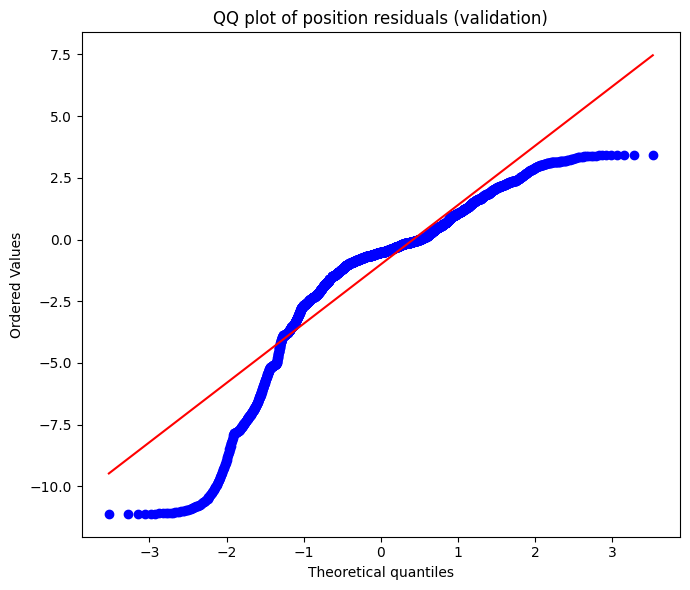

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize
from sklearn.model_selection import train_test_split
import scipy.stats as stats

# 0) Load data
df = pd.read_csv('cf_pair25_v1.csv')

# 1) Train/test split by follower vehicle (8:2)
unique_pairs = df['Vehicle_ID_f'].unique()
train_ids, test_ids = train_test_split(unique_pairs, test_size=0.2, random_state=42)
train_data = df[df['Vehicle_ID_f'].isin(train_ids)].copy()
test_data  = df[df['Vehicle_ID_f'].isin(test_ids)].copy()
print(f"Training pairs: {len(train_ids)} | Testing pairs: {len(test_ids)}")

# 2) IDM model + simulation
def idm_model(s, v, delta_v, params, T=1.5, v0=30.0, s0=1.0, delta=4):
    a, b = params
    a = max(a, 1e-6); b = max(b, 1e-6); s = max(s, 1e-3)
    s_star = s0 + v*T + (v*delta_v)/(2*np.sqrt(a*b))
    return a * (1 - (v/v0)**delta - (s_star/s)**2)

def simulate_vehicle(group, params, dt=0.1):
    v_f0 = group['v_f'].iloc[0]; x_f0 = group['x_f'].iloc[0]
    v_l = group['v_l'].values; x_l = group['x_l'].values; length_l = group['length_l'].values
    v_sim = [v_f0]; x_sim = [x_f0]
    for i in range(1, len(group)):
        s = x_l[i] - x_sim[-1] - length_l[i]
        delta_v = v_sim[-1] - v_l[i]
        acc = idm_model(s, v_sim[-1], delta_v, params)
        new_v = max(0.0, v_sim[-1] + acc*dt)
        new_x = x_sim[-1] + new_v*dt
        v_sim.append(new_v); x_sim.append(new_x)
    return np.array(v_sim), np.array(x_sim)

# 3) Negative log-likelihood (Skew-Normal errors)
def neg_log_likelihood_skewnorm(params, df, dt=0.1):
    a, b, alpha = params
    total_nll = 0.0
    n_obs = 0
    for _, grp in df.groupby('Vehicle_ID_f'):
        x_obs = grp['x_f'].values
        _, x_sim = simulate_vehicle(grp, (a, b), dt=dt)
        n = min(len(x_obs), len(x_sim))
        resid = x_obs[:n] - x_sim[:n]
        n_obs += len(resid)
        const = stats.skewnorm.logpdf(resid, alpha, loc=0, scale=1).sum()
        total_nll -= const
    return total_nll, n_obs

# Wrapper for optimizer (must return scalar)
def nll_wrapper(params, df, dt=0.1):
    nll, _ = neg_log_likelihood_skewnorm(params, df, dt)
    return nll

# 4) Calibrate (MLE on position with skew-normal)
initial_guess = [1.0, 2.0, -5.0]  # [a, b, alpha]
bounds = [(0.1, 5.0), (0.1, 5.0), (-10.0, 10.0)]
res = minimize(nll_wrapper, initial_guess,
               args=(train_data,), bounds=bounds, method='L-BFGS-B')
params_mle = res.x
nll_value, n_obs = neg_log_likelihood_skewnorm(params_mle, train_data)
print("Calibrated (MLE with skew-normal) params [a, b, alpha]:", params_mle)

# 5) Model selection criteria
k = len(params_mle)
AIC = 2*k + 2*nll_value
BIC = k*np.log(n_obs) + 2*nll_value
print(f"AIC: {AIC:.2f}, BIC: {BIC:.2f}")

# 6) Validation on position and speed
def evaluate_rmse(df, params, dt=0.1):
    a, b, alpha = params
    rows_pos, rows_spd = [], []
    for vid, grp in df.groupby('Vehicle_ID_f'):
        x_obs = grp['x_f'].values; v_obs = grp['v_f'].values
        v_sim, x_sim = simulate_vehicle(grp, (a, b), dt=dt)
        n_pos = min(len(x_obs), len(x_sim)); n_spd = min(len(v_obs), len(v_sim))
        resid_pos = x_obs[:n_pos] - x_sim[:n_pos]
        resid_spd = v_obs[:n_spd] - v_sim[:n_spd]
        rows_pos.append({'Vehicle_ID_f': vid, 'RMSE_position': np.sqrt(np.mean(resid_pos**2))})
        rows_spd.append({'Vehicle_ID_f': vid, 'RMSE_speed': np.sqrt(np.mean(resid_spd**2))})
    return pd.DataFrame(rows_pos), pd.DataFrame(rows_spd)

rmse_pos_df, rmse_speed_df = evaluate_rmse(test_data, params_mle, dt=0.1)
print("\nValidation (position RMSE) summary:"); print(rmse_pos_df.describe())
print("\nValidation (speed RMSE) summary:"); print(rmse_speed_df.describe())

# 7) Residual diagnostics
def collect_position_residuals(df, params, dt=0.1):
    a, b, alpha = params
    resid_all, fitted_all = [], []
    for _, grp in df.groupby('Vehicle_ID_f'):
        x_obs = grp['x_f'].values
        _, x_sim = simulate_vehicle(grp, (a, b), dt=dt)
        n = min(len(x_obs), len(x_sim))
        resid_all.append(x_obs[:n] - x_sim[:n])
        fitted_all.append(x_sim[:n])
    return np.concatenate(resid_all), np.concatenate(fitted_all)

resid_all, fitted_all = collect_position_residuals(test_data, params_mle, dt=0.1)

plt.figure(figsize=(10,6))
sns.histplot(resid_all, bins=30, kde=True, color="skyblue")
plt.title("Distribution of position residuals (validation)")
plt.xlabel("Residual (m)"); plt.ylabel("Frequency"); plt.tight_layout(); plt.show()

# Normality test (still useful for diagnostics)
subset = resid_all[:min(len(resid_all), 5000)]
stat, p_value = stats.shapiro(subset)
print(f"Shapiro–Wilk on position residuals: stat={stat:.3f}, p={p_value:.3f}")
print("Interpretation:", "Fail to reject normality (p>0.05)" if p_value > 0.05 else "Reject normality (p<=0.05)")

plt.figure(figsize=(7,6))
stats.probplot(resid_all, dist="norm", plot=plt)
plt.title("QQ plot of position residuals (validation)")
plt.tight_layout(); plt.show()
